<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

inputs = tf.keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = tf.keras.layers.Reshape(target_shape=(784,))(h)
preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [13]:
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)


@keras.saving.register_keras_serializable()
class DenseModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dense01 = tf.keras.layers.Dense(units=64,
            activation=tf.keras.activations.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        self.dense02 =  tf.keras.layers.Dense(units=10,
            activation=tf.keras.activations.softmax)

    def call(self, inputs, training=False):
        x = self.dense01(inputs=inputs)
        x = self.dropout(inputs=x, training=training)
        y = self.dense02(inputs=x)
        return y

    @tf.function
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(inputs=x, training=True)
            loss = self.compute_loss(y=y, y_pred=y_pred)
        grads = tape.gradient(target=loss,
            sources=self.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars=zip(
            grads, self.trainable_variables))

        for m in self.metrics:
            if m.name=="loss":
                m.update_state(values=loss)
            else:
                m.update_state(y_true=y, y_pred=y_pred)

        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        x, y = data
        y_pred = self(inputs=x)
        loss = self.compute_loss(y=y, y_pred=y_pred)

        for m in self.metrics:
            if m.name=="loss":
                m.update_state(values=loss)
            else:
                m.update_state(y_true=y, y_pred=y_pred)

        return {m.name: m.result() for m in self.metrics}

training_model = DenseModel()
training_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
    ]
)

Training duration: 44s


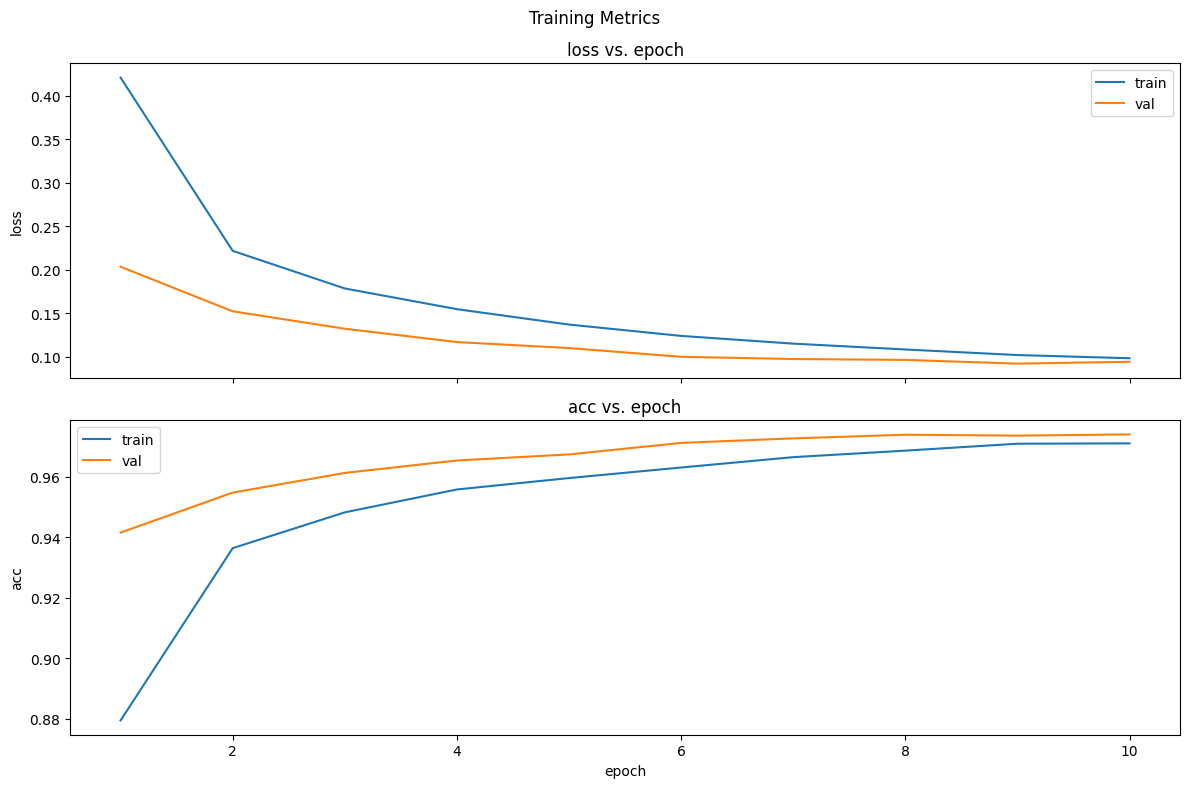

Test: loss=0.09, acc=0.97


In [14]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("models", exist_ok=True)
ckpt_path = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="val_acc",
    mode="max", save_best_only=True, save_weights_only=True,
    filepath=ckpt_path)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
    mode="min", patience=1, factor=0.9)

start_time = time.time()
history = training_model.fit(x=ds_train, validation_data=ds_test,
    callbacks=[ckptModel, reduceLR], epochs=10, verbose=0)
print("Training duration: %2.fs"%(time.time() - start_time))

df_history = pd.DataFrame(history.history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
axes[1].set_xlabel(xlabel="epoch")
for ax, m in zip(axes, ["loss", "acc"]):
    g = sns.lineplot(ax=ax, data=df_history, label="train",
        x="epoch", y=f"{m}")
    g = sns.lineplot(ax=ax, data=df_history, label="val",
        x="epoch", y=f"val_{m}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

training_model.load_weights(ckpt_path)
loss, acc = training_model.evaluate(x=ds_test, verbose=0)
print(f"Test: loss={loss:.2f}, acc={acc:.2f}")

In [15]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import numpy as np

inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)

model_path = "models/inference.keras"
inference_model.save(filepath=model_path)

inference_model = tf.keras.models.load_model(filepath=model_path)

idx = 79
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
y_pred = inference_model(x_pred)
print("y_true:", y_test[idx], "y_pred:", np.argmax(y_pred))

y_true: 7 y_pred: 7
